# Sensor Data Processing

This notebook provides a reusable function to generate combined sensor data (temperature, humidity, upper_irradiance, lower_irradiance + power) for any sensor IDs.

## Setup

Install required dependencies from `requirements.txt`:
```bash
pip install -r requirements.txt
```

Required packages (from requirements.txt):
- `pandas>=2.0.0`: Data manipulation and Excel file handling
- `numpy>=1.24.0`: Numerical operations  
- `openpyxl>=3.1.0`: Excel file reading/writing support
- `matplotlib>=3.7.0`: Plotting (optional, for visualization)


In [19]:
# Import required packages (as specified in requirements.txt)
import pandas as pd
import numpy as np
import os


In [20]:
def generate_combined_data(sensor_ids, power_data_paths, output_dir='data'):
    """
    Generate combined data (temperature, humidity, upper_irradiance, lower_irradiance + power) for specified sensors.
    Each sensor is saved to a separate file.
    
    Parameters:
    -----------
    sensor_ids : list
        List of sensor IDs to process (e.g., [17, 20])
    power_data_paths : dict
        Dictionary mapping month names to file paths
        e.g., {'august': '../aug_2025/Area_1/august_fivemin_power.csv',
               'september': '../sep_2025/Area_1/september_fivemin_power.csv',
               'october': '../oct_2025/Area_1/october_fivemin_power.csv'}
    output_dir : str
        Directory to save output files (default: 'data')
    
    Returns:
    --------
    dict : Dictionary mapping sensor_id to the combined dataframe
    """
    import os
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Read raw sensor data
    file_path = 'data/raw/panel_temperature_and_light_raw_dataset_MK_2025_december_3.xlsx'
    df = pd.read_excel(file_path)
    
    # Filter for specified sensor IDs
    columns_to_process = ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance(μW/cm²)', 'sensor_id']
    sensor_data = df[df['sensor_id'].isin(sensor_ids)][columns_to_process].copy()
    sensor_data['datetime'] = pd.to_datetime(sensor_data['datetime'])
    
    print(f"Processing sensors: {sensor_ids}")
    print(f"Total raw data points: {len(sensor_data)}")
    
    # Process each sensor
    sensor_results = {}
    
    for sensor_id in sensor_ids:
        print(f"\n{'='*60}")
        print(f"Processing sensor_id: {sensor_id}")
        print(f"{'='*60}")
        
        # Filter data for this sensor
        sensor_specific_data = sensor_data[sensor_data['sensor_id'] == sensor_id][
            ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance(μW/cm²)']
        ].copy()
        
        # Remove duplicates
        sensor_specific_data = sensor_specific_data.drop_duplicates(subset=['datetime'], keep='first')
        sensor_specific_data = sensor_specific_data.sort_values('datetime').reset_index(drop=True)
        
        # Set datetime as index
        sensor_indexed = sensor_specific_data.set_index('datetime')
        
        # Create 10-minute grid starting from 2025-08-12 17:00:00
        start_time = pd.Timestamp('2025-08-12 17:00:00')
        end_time = sensor_indexed.index.max()
        
        # Align start_time
        data_start = sensor_indexed.index.min()
        if data_start < start_time:
            resample_start = start_time
        else:
            time_since_start = (data_start - start_time).total_seconds() / 60
            intervals_since_start = int((time_since_start // 10) + (1 if time_since_start % 10 > 0 else 0))
            resample_start = start_time + pd.Timedelta(minutes=10 * intervals_since_start)
        
        # Create date range with 10-minute frequency
        resample_range = pd.date_range(start=resample_start, end=end_time, freq='10min')
        
        # Union original timestamps and grid
        original_index = sensor_indexed.index
        combined_index = original_index.union(resample_range).sort_values()
        
        # Reindex to combined index
        sensor_combined = sensor_indexed.reindex(combined_index)
        
        # Interpolate
        columns_to_interpolate = ['upper_temp_C', 'upper_humidity', 'upper_irradiance(μW/cm²)']
        for col in columns_to_interpolate:
            sensor_combined[col] = sensor_combined[col].interpolate(method='time', limit_direction='both')
        
        # Select only grid timestamps
        sensor_resampled = sensor_combined.loc[resample_range]
        sensor_final = sensor_resampled.reset_index()
        sensor_final.rename(columns={'index': 'datetime'}, inplace=True)
        
        # Convert temperature from Celsius to Fahrenheit
        sensor_final['upper_temp_F'] = sensor_final['upper_temp_C'] * 9/5 + 32
        sensor_final = sensor_final.drop(columns=['upper_temp_C'])
        
        # Convert irradiance from μW/cm² to W/m²
        # 1 μW = 1 × 10^-6 W
        # 1 cm² = 1 × 10^-4 m²
        # So: 1 μW/cm² = (1 × 10^-6 W) / (1 × 10^-4 m²) = 0.01 W/m²
        sensor_final['upper_irradiance_W_per_m2'] = sensor_final['upper_irradiance(μW/cm²)'] * 0.01
        sensor_final = sensor_final.drop(columns=['upper_irradiance(μW/cm²)'])
        
        sensor_final['sensor_id'] = sensor_id
        
        print(f"  Resampled data shape: {sensor_final.shape}")
        print(f"  Time range: {sensor_final['datetime'].min()} to {sensor_final['datetime'].max()}")
        
        # Process power data - use eu column matching sensor_id
        print(f"\n  Processing power data for eu_{sensor_id}...")
        eu_column_name = f'eu_{sensor_id} (W)'
        all_power_data = []
        
        for month, power_file in power_data_paths.items():
            try:
                df_power = pd.read_csv(power_file)
                df_power['datetime'] = pd.to_datetime(df_power['time (min)'])
                
                # Check if the eu column exists for this sensor_id
                if eu_column_name not in df_power.columns:
                    print(f"    {month}: Column '{eu_column_name}' not found, skipping")
                    continue
                
                # Select the eu column matching sensor_id
                power_data = df_power[['datetime', eu_column_name]].copy()
                power_data = power_data.rename(columns={eu_column_name: 'power_W'})
                
                # Filter from start_time to end
                power_filtered = power_data[power_data['datetime'] >= start_time].copy()
                power_filtered = power_filtered.drop_duplicates(subset=['datetime'], keep='first')
                
                # Filter to 10-minute intervals
                end_time_power = power_filtered['datetime'].max()
                resample_range_power = pd.date_range(start=start_time, end=end_time_power, freq='10min')
                power_final = power_filtered[power_filtered['datetime'].isin(resample_range_power)].copy()
                power_final = power_final.sort_values('datetime').reset_index(drop=True)
                
                all_power_data.append(power_final)
                print(f"    {month}: {len(power_final)} data points")
            except Exception as e:
                print(f"    {month}: Error - {e}")
        
        if all_power_data:
            # Combine all power data
            combined_power = pd.concat(all_power_data, ignore_index=True)
            combined_power = combined_power.sort_values('datetime').reset_index(drop=True)
            combined_power['datetime'] = pd.to_datetime(combined_power['datetime'])
            
            # Merge sensor data with power data
            sensor_final['datetime'] = pd.to_datetime(sensor_final['datetime'])
            combined_sensor_data = pd.merge(
                sensor_final,
                combined_power,
                on='datetime',
                how='inner'
            )
            combined_sensor_data = combined_sensor_data.sort_values('datetime').reset_index(drop=True)
        else:
            combined_sensor_data = sensor_final.copy()
            print("    Warning: No power data available")
        
        # Round all numeric columns to 2 decimal places
        numeric_columns = combined_sensor_data.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            combined_sensor_data[col] = combined_sensor_data[col].round(2)
        
        # Save to file
        output_file = os.path.join(output_dir, f'sensor_{sensor_id}_combined_data.xlsx')
        combined_sensor_data.to_excel(output_file, index=False)
        
        sensor_results[sensor_id] = combined_sensor_data
        
        print(f"\n  Saved to: {output_file}")
        print(f"  Final data shape: {combined_sensor_data.shape}")
        print(f"  Columns: {combined_sensor_data.columns.tolist()}")
    
    print(f"\n{'='*60}")
    print(f"Processing complete!")
    print(f"{'='*60}")
    
    return sensor_results


In [17]:
# Example usage: Generate combined data for sensors #
power_data_paths = {
    'august': '../aug_2025/Area_1/august_fivemin_power.csv',
    'september': '../sep_2025/Area_1/september_fivemin_power.csv',
    'october': '../oct_2025/Area_1/october_fivemin_power.csv'
}

# Call the function
results = generate_combined_data(
    sensor_ids=[23],
    power_data_paths=power_data_paths,
    output_dir='data'
)

# Display summary
for sensor_id, df in results.items():
    print(f"\nSensor {sensor_id}:")
    print(f"  Rows: {len(df)}")
    print(f"  Time range: {df['datetime'].min()} to {df['datetime'].max()}")
    print(f"  Columns: {df.columns.tolist()}")


Processing sensors: [23]
Total raw data points: 8146

Processing sensor_id: 23
  Resampled data shape: (8152, 5)
  Time range: 2025-08-19 17:10:00 to 2025-10-15 07:40:00

  Processing power data for eu_23...
    august: 2778 data points
    september: 4320 data points
    october: 4464 data points

  Saved to: data\sensor_23_combined_data.xlsx
  Final data shape: (8152, 6)
  Columns: ['datetime', 'upper_humidity', 'upper_temp_F', 'upper_irradiance_W_per_m2', 'sensor_id', 'power_W']

Processing complete!

Sensor 23:
  Rows: 8152
  Time range: 2025-08-19 17:10:00 to 2025-10-15 07:40:00
  Columns: ['datetime', 'upper_humidity', 'upper_temp_F', 'upper_irradiance_W_per_m2', 'sensor_id', 'power_W']


In [ ]:
# Read irradiance data from site file
irradiance_file = 'data/raw/irradiance-from-site.csv'
df_irradiance = pd.read_csv(irradiance_file)

# Parse datetime
df_irradiance['datetime'] = pd.to_datetime(df_irradiance['Site Time'])
df_irradiance = df_irradiance.sort_values('datetime').reset_index(drop=True)

# Use Irradiance column as W/m²
df_irradiance['irradiance_W_per_m2'] = df_irradiance['Irradiance - bottom']

print(f"Total data points: {len(df_irradiance)}")
print(f"Time range: {df_irradiance['datetime'].min()} to {df_irradiance['datetime'].max()}")
print(f"\nFirst few rows:")
print(df_irradiance[['datetime', 'Irradiance - bottom', 'irradiance_W_per_m2']].head(10))


Total data points: 23328
Time range: 2025-08-12 00:00:00 to 2025-10-31 23:55:00

First few rows:
             datetime  Irradiance - bottom  irradiance_W_per_m2
0 2025-08-12 00:00:00                  0.0                  0.0
1 2025-08-12 00:05:00                  0.0                  0.0
2 2025-08-12 00:10:00                  0.0                  0.0
3 2025-08-12 00:15:00                  0.0                  0.0
4 2025-08-12 00:20:00                  0.0                  0.0
5 2025-08-12 00:25:00                  0.0                  0.0
6 2025-08-12 00:30:00                  0.0                  0.0
7 2025-08-12 00:35:00                  0.0                  0.0
8 2025-08-12 00:40:00                  0.0                  0.0
9 2025-08-12 00:45:00                  0.0                  0.0


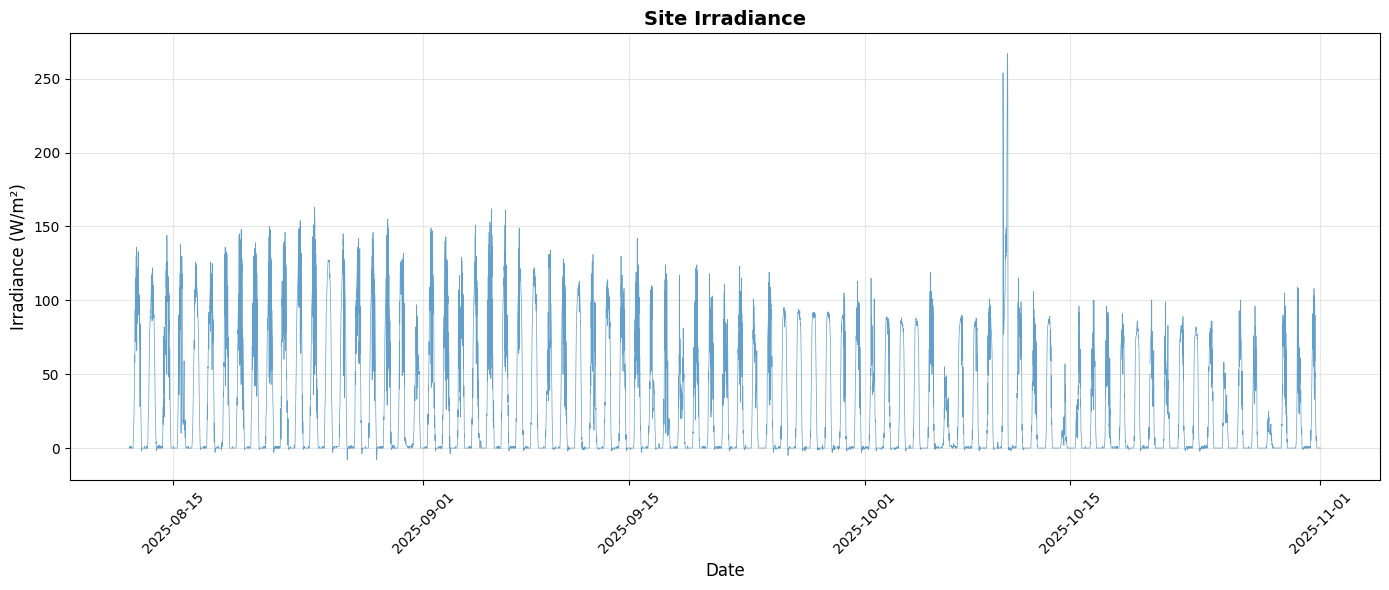


Summary Statistics:
  Irradiance (W/m²):
    Min: -8.00
    Max: 267.00
    Mean: 28.86


In [29]:
# Plot the irradiance data
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot irradiance data in W/m²
ax.plot(df_irradiance['datetime'], df_irradiance['irradiance_W_per_m2'], linewidth=0.5, alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Irradiance (W/m²)', fontsize=12)
ax.set_title('Site Irradiance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nSummary Statistics:")
print(f"  Irradiance (W/m²):")
print(f"    Min: {df_irradiance['irradiance_W_per_m2'].min():.2f}")
print(f"    Max: {df_irradiance['irradiance_W_per_m2'].max():.2f}")
print(f"    Mean: {df_irradiance['irradiance_W_per_m2'].mean():.2f}")


## Comparison: Site Irradiance vs Sensor 1 Irradiance

Compare site irradiance data with sensor 1 irradiance data on the same plot.


In [30]:
# Read sensor 1 combined data
sensor1_file = 'data/sensor_1_combined_data.xlsx'
df_sensor1 = pd.read_excel(sensor1_file)

# Parse datetime
df_sensor1['datetime'] = pd.to_datetime(df_sensor1['datetime'])
df_sensor1 = df_sensor1.sort_values('datetime').reset_index(drop=True)

print(f"Sensor 1 data points: {len(df_sensor1)}")
print(f"Time range: {df_sensor1['datetime'].min()} to {df_sensor1['datetime'].max()}")
print(f"\nFirst few rows:")
print(df_sensor1[['datetime', 'upper_irradiance_W_per_m2']].head(10))


Sensor 1 data points: 11561
Time range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00

First few rows:
             datetime  upper_irradiance_W_per_m2
0 2025-08-12 17:10:00                     177.35
1 2025-08-12 17:20:00                     157.30
2 2025-08-12 17:30:00                     100.22
3 2025-08-12 17:40:00                     104.09
4 2025-08-12 17:50:00                     128.08
5 2025-08-12 18:00:00                     122.37
6 2025-08-12 18:10:00                      95.50
7 2025-08-12 18:20:00                      80.72
8 2025-08-12 18:30:00                      72.61
9 2025-08-12 18:40:00                      68.68


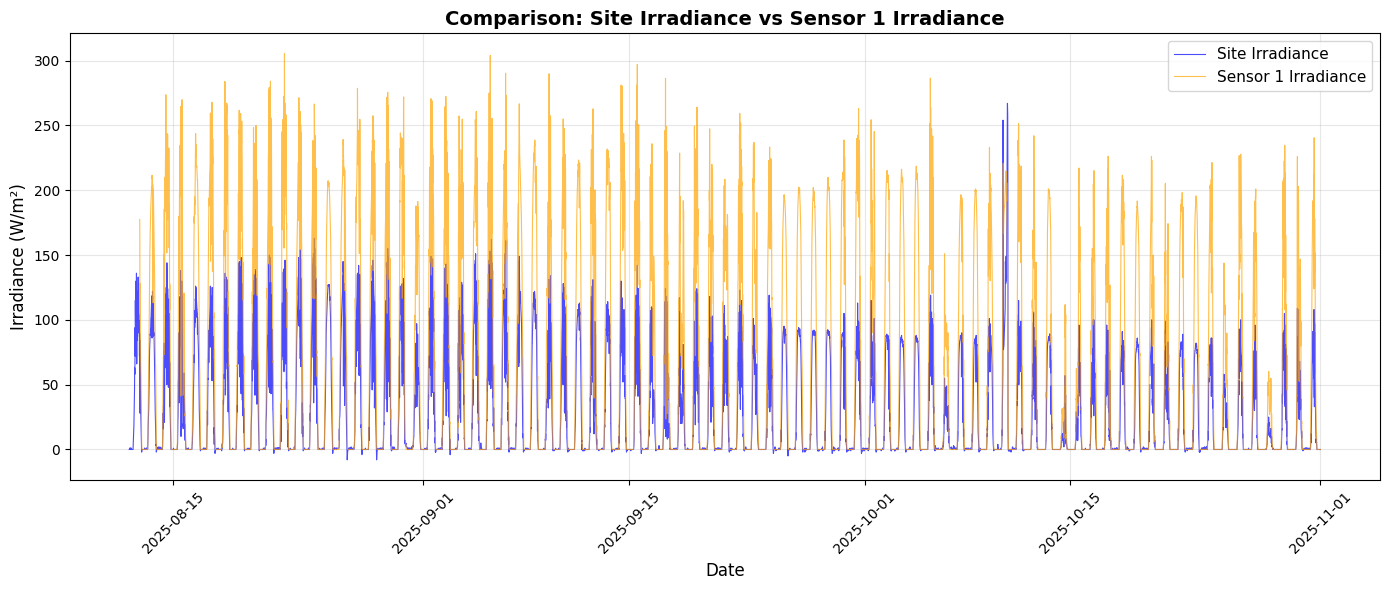


Comparison Statistics:
  Site Irradiance (W/m²):
    Min: -8.00
    Max: 267.00
    Mean: 28.86

  Sensor 1 Irradiance (W/m²):
    Min: 0.00
    Max: 305.32
    Mean: 63.63


In [31]:
# Plot both datasets on the same plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot site irradiance
ax.plot(df_irradiance['datetime'], df_irradiance['irradiance_W_per_m2'], 
        label='Site Irradiance', linewidth=0.8, alpha=0.7, color='blue')

# Plot sensor 1 irradiance
ax.plot(df_sensor1['datetime'], df_sensor1['upper_irradiance_W_per_m2'], 
        label='Sensor 1 Irradiance', linewidth=0.8, alpha=0.7, color='orange')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Irradiance (W/m²)', fontsize=12)
ax.set_title('Comparison: Site Irradiance vs Sensor 1 Irradiance', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display comparison statistics
print("\nComparison Statistics:")
print(f"  Site Irradiance (W/m²):")
print(f"    Min: {df_irradiance['irradiance_W_per_m2'].min():.2f}")
print(f"    Max: {df_irradiance['irradiance_W_per_m2'].max():.2f}")
print(f"    Mean: {df_irradiance['irradiance_W_per_m2'].mean():.2f}")
print(f"\n  Sensor 1 Irradiance (W/m²):")
print(f"    Min: {df_sensor1['upper_irradiance_W_per_m2'].min():.2f}")
print(f"    Max: {df_sensor1['upper_irradiance_W_per_m2'].max():.2f}")
print(f"    Mean: {df_sensor1['upper_irradiance_W_per_m2'].mean():.2f}")


## Comparison: Site Temperature vs Sensor 1 Temperature

Compare site temperature data with sensor 1 temperature data on the same plot.


In [40]:
# Read temperature data from site file
temperature_file = 'data/raw/temperature-from-site.csv'
df_temperature_site = pd.read_csv(temperature_file)

# Parse datetime
df_temperature_site['datetime'] = pd.to_datetime(df_temperature_site['Site Time'])
df_temperature_site = df_temperature_site.sort_values('datetime').reset_index(drop=True)

# Extract temperature column (it has a long name)
temp_col = df_temperature_site.columns[1]  # Get the temperature column name
df_temperature_site['temperature_F'] = df_temperature_site[temp_col]

print(f"Site temperature data points: {len(df_temperature_site)}")
print(f"Time range: {df_temperature_site['datetime'].min()} to {df_temperature_site['datetime'].max()}")
print(f"\nFirst few rows:")
print(df_temperature_site[['datetime', 'temperature_F']].head(10))


Site temperature data points: 23328
Time range: 2025-08-12 00:00:00 to 2025-10-31 23:55:00

First few rows:
             datetime  temperature_F
0 2025-08-12 00:00:00         66.218
1 2025-08-12 00:05:00         66.758
2 2025-08-12 00:10:00         66.866
3 2025-08-12 00:15:00         66.416
4 2025-08-12 00:20:00         65.930
5 2025-08-12 00:25:00         65.714
6 2025-08-12 00:30:00         65.714
7 2025-08-12 00:35:00         65.948
8 2025-08-12 00:40:00         65.840
9 2025-08-12 00:45:00         66.002


In [41]:
# Read sensor 1 data (if not already loaded)
if 'df_sensor1' not in locals():
    sensor1_file = 'data/sensor_1_combined_data.xlsx'
    df_sensor1 = pd.read_excel(sensor1_file)
    df_sensor1['datetime'] = pd.to_datetime(df_sensor1['datetime'])
    df_sensor1 = df_sensor1.sort_values('datetime').reset_index(drop=True)

print(f"Sensor 1 temperature data points: {len(df_sensor1)}")
print(f"Time range: {df_sensor1['datetime'].min()} to {df_sensor1['datetime'].max()}")
print(f"\nFirst few rows:")
print(df_sensor1[['datetime', 'upper_temp_F']].head(10))


Sensor 1 temperature data points: 11561
Time range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00

First few rows:
             datetime  upper_temp_F
0 2025-08-12 17:10:00         95.05
1 2025-08-12 17:20:00         94.09
2 2025-08-12 17:30:00         92.09
3 2025-08-12 17:40:00         88.96
4 2025-08-12 17:50:00         87.62
5 2025-08-12 18:00:00         88.59
6 2025-08-12 18:10:00         87.63
7 2025-08-12 18:20:00         86.04
8 2025-08-12 18:30:00         84.76
9 2025-08-12 18:40:00         84.31


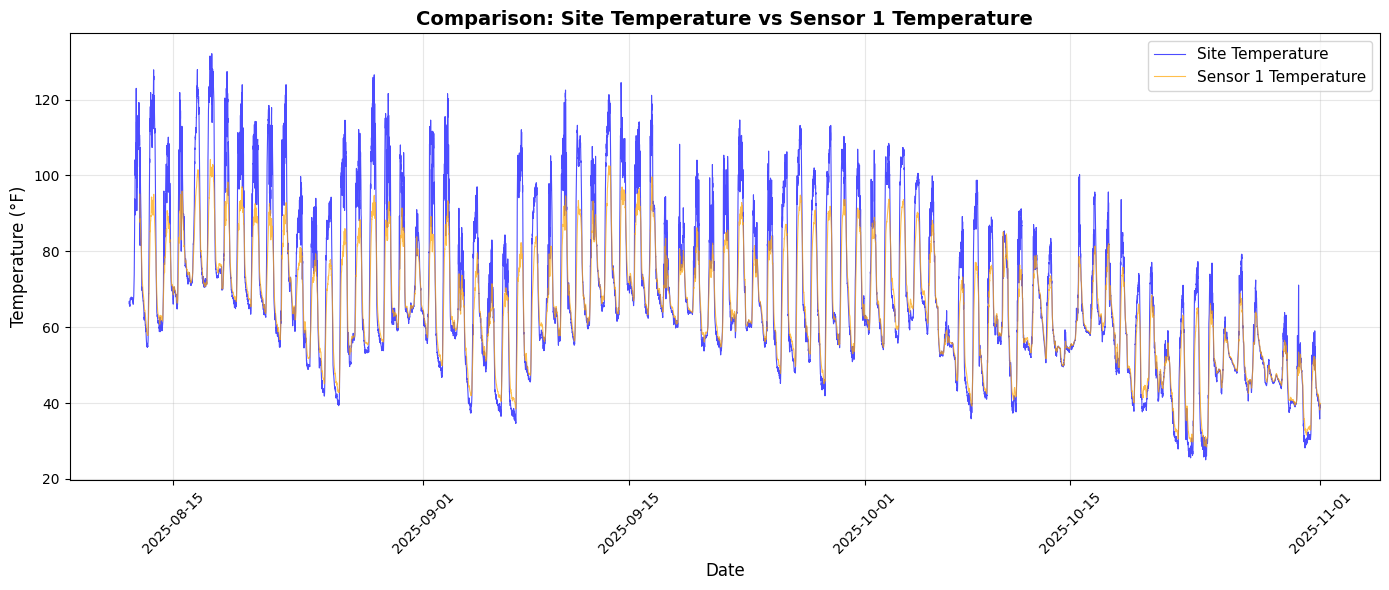


Comparison Statistics:
  Site Temperature (°F):
    Min: 25.03
    Max: 132.10
    Mean: 69.15

  Sensor 1 Temperature (°F):
    Min: 28.43
    Max: 104.22
    Mean: 65.40


In [42]:
# Plot both temperature datasets on the same plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot site temperature
ax.plot(df_temperature_site['datetime'], df_temperature_site['temperature_F'], 
        label='Site Temperature', linewidth=0.8, alpha=0.7, color='blue')

# Plot sensor 1 temperature
ax.plot(df_sensor1['datetime'], df_sensor1['upper_temp_F'], 
        label='Sensor 1 Temperature', linewidth=0.8, alpha=0.7, color='orange')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°F)', fontsize=12)
ax.set_title('Comparison: Site Temperature vs Sensor 1 Temperature', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display comparison statistics
print("\nComparison Statistics:")
print(f"  Site Temperature (°F):")
print(f"    Min: {df_temperature_site['temperature_F'].min():.2f}")
print(f"    Max: {df_temperature_site['temperature_F'].max():.2f}")
print(f"    Mean: {df_temperature_site['temperature_F'].mean():.2f}")
print(f"\n  Sensor 1 Temperature (°F):")
print(f"    Min: {df_sensor1['upper_temp_F'].min():.2f}")
print(f"    Max: {df_sensor1['upper_temp_F'].max():.2f}")
print(f"    Mean: {df_sensor1['upper_temp_F'].mean():.2f}")
